# Examine trans effect of TP53 Hotspot mutation in Colon Cancer

### Specifically examine Protein Abundance of TP53, AURKA, CDK1, XPO1, and STK11

#### Library Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import cptac
import cptac.utils as ut

import seaborn as sns
import matplotlib.pyplot as plt

#Use Colon cancer object
co = cptac.Colon()

### Use parse hotspot utility to analyze TP53 hotspot mutation in Colon cancer

#### Get somatic mutation data from cptac

In [2]:
somatic_mutations = co.get_somatic_mutation()

#### Use parse hotspot utility

In [3]:
vis, binary, detailed, dictionary = ut.parse_hotspot('../../HotspotClusterFiles/DanHeader_MyData.maf.3D_Proximity.pairwise.recurrence.l0.r10.clusters', somatic_mutations)

In [4]:
vis

,hotspot_id,patients_within
0,A2M,6.0
1,ABCB6,6.0
2,ACAA1,11.0
3,ACACB,2.0
4,ACADSB,5.0
5,ACAP1,4.0
6,ACBD3,3.0
7,ACLY,6.0
8,ACP5,20.0
9,ACVRL1,19.0


As we can see, TP53 has 2 hotspots in Colon cancer

#### Select only TP53 Hotspots

In [5]:
#There are 2 TP53 hotspots
TP53_Hotspots = detailed[['TP53','TP53_1']]
TP53_Hotspots

,TP53,TP53_1
sample_id,,
S001,No,No
S002,No,No
S003,No,No
S004,No,No
S005,No,No
S006,No,Yes
S007,No,No
S008,No,No
S009,No,No


#### Make binary column for samples that have a TP53 Hotspot Mutation

In [6]:
TP53_Hotspots['Hotspot_Mutation'] = ''
for ind, row in TP53_Hotspots.iterrows():
    for col in TP53_Hotspots.columns:
        if row[col] == 'Yes_HS':
            TP53_Hotspots.loc[ind,'Hotspot_Mutation'] = 'TP53_Hotspot_Mutation'
        if row[col] == 'Yes':
            TP53_Hotspots.loc[ind,'Hotspot_Mutation'] = 'TP53_Hotspot_Mutation'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

#### Grab only the binary yes/no hotspot mutation

In [7]:
binary_hotspots = TP53_Hotspots['Hotspot_Mutation']

In [8]:
TP53_Hotspots

,TP53,TP53_1,Hotspot_Mutation
sample_id,,,
S001,No,No,
S002,No,No,
S003,No,No,
S004,No,No,
S005,No,No,
S006,No,Yes,TP53_Hotspot_Mutation
S007,No,No,
S008,No,No,
S009,No,No,


#### Get Proteomic data, append Binary hotspot mutation column

In [9]:
#Use join omics to mutations
proteomics_df = co.join_omics_to_mutations(omics_genes=['TP53','AURKA','CDK1','XPO1','STK11'], omics_df_name='proteomics', mutations_genes='TP53')

#Remove Non-Tumor Samples
proteomics_df = proteomics_df.loc[proteomics_df['Sample_Status'] == 'Tumor']

#Remove columns that are not needed
proteomics_df = proteomics_df.drop(['TP53_Location','Sample_Status'],axis=1)
proteomics_df['TP53_Hotspot_Mutation'] = binary_hotspots

#Show df
proteomics_df.head()

<bound method NDFrame.head of Name        TP53_proteomics  AURKA_proteomics  CDK1_proteomics  \
Patient_ID                                                       
S001                    NaN               NaN              NaN   
S002                 -0.489            -0.311           -0.569   
S003                 -0.796               NaN           -0.557   
S004                    NaN               NaN           -0.222   
S005                 -1.390               NaN            0.486   
...                     ...               ...              ...   
S106                    NaN               NaN            0.181   
S107                  0.850               NaN            0.478   
S108                    NaN               NaN            0.354   
S109                    NaN               NaN              NaN   
S110                 -0.848               NaN           -0.119   

Name        XPO1_proteomics  STK11_proteomics  \
Patient_ID                                      
S001         

#### Classify every sample according to TP53 Mutation Status. Use: Wildtype, Hotspot_Missense, Other_Missense, Truncation

Which should take precedence? If there is a hotspot mutation, and is also a truncating mutation in the same sample?

There are 9 samples with a mutation in the hotspot. 4 of these also have truncating mutations, however, leaving only 5 hotspot missense samples.

In [10]:
for ind, row in proteomics_df.iterrows():
    if row['TP53_Mutation_Status'] == 'Wildtype_Tumor':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Wildtype'
    
    if row['TP53_Hotspot_Mutation'] != 'TP53_Hotspot_Mutation':
        if 'nonsynonymous SNV' in row['TP53_Mutation'] or 'nonframeshift deletion' in row['TP53_Mutation'] or 'nonframeshift insertion' in row['TP53_Mutation']:
            proteomics_df.loc[ind, 'TP53_Categorical'] = 'Other_Missense'
            
    if row['TP53_Hotspot_Mutation'] == 'TP53_Hotspot_Mutation':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Hotspot_Missense'
        
    if 'frameshift insertion' in row['TP53_Mutation'] or 'frameshift deletion' in row['TP53_Mutation'] or 'stopgain' in row['TP53_Mutation']:
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Truncation'
        
        
        
proteomics_df = proteomics_df.drop(['TP53_Mutation', 'TP53_Mutation_Status', 'TP53_Hotspot_Mutation'], axis = 1)
proteomics_df

Name,TP53_proteomics,AURKA_proteomics,CDK1_proteomics,XPO1_proteomics,STK11_proteomics,TP53_Categorical
Patient_ID,,,,,,
S001,NaN,NaN,NaN,NaN,NaN,Other_Missense
S002,-0.4890,-0.311,-0.5690,0.1610,NaN,Truncation
S003,-0.7960,NaN,-0.5570,0.0062,NaN,Wildtype
S004,NaN,NaN,-0.2220,0.1490,-0.6070,Wildtype
S005,-1.3900,NaN,0.4860,0.3410,NaN,Truncation
S006,NaN,NaN,0.5330,0.0259,NaN,Hotspot_Missense
S007,NaN,NaN,0.0605,0.2520,NaN,Wildtype
S008,NaN,NaN,0.2400,0.0469,-0.1710,Other_Missense
S009,-0.2630,NaN,1.2000,0.0196,NaN,Wildtype


### Note:

Note that there are 9 samples with a missense mutation in the hotspot, however, 4 of these samples also have a truncating mutation present. These are classified as truncation, not hotspot missense samples.

### Perform t-tests on each protein, comparing Hotspot-Wildtype, Hotspot-Truncation, and Hotspot-Other Missense Mutations

In [11]:
for col in proteomics_df:
    if col != 'TP53_Categorical':
        hotspot_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Hotspot_Missense'][col].dropna()
        truncation_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Truncation'][col].dropna()
        other_missense_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Other_Missense'][col].dropna()
        wt_df = proteomics_df.loc[proteomics_df['TP53_Categorical'] == 'Wildtype'][col]
        
        #Hotspot-WT comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, wt_df)
        print("Omics: ", col, "\nComparison: Hotspot vs. Wildtype \nP-Value: ", str(pval))
        
        #Hotspot-Truncation comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, truncation_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Truncation \nP-Value: ", str(pval))
        
        #Hotspot-Other Missense comparison
        stat, pval = scipy.stats.ttest_ind(hotspot_df, other_missense_df)
        print("\nOmics: ", col, "\nComparison: Hotspot vs. Other Missense \nP-Value: ", str(pval))
        print("\n\n")
        

Omics:  TP53_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  TP53_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.014251935186163132

Omics:  TP53_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.8967642229256507



Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  nan

Omics:  AURKA_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  nan



Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.4465782137329324

Omics:  CDK1_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  0.6794812230227644



Omics:  XPO1_proteomics 
Comparison: Hotspot vs. Wildtype 
P-Value:  nan

Omics:  XPO1_proteomics 
Comparison: Hotspot vs. Truncation 
P-Value:  0.822100398249674

Omics:  XPO1_proteomics 
Comparison: Hotspot vs. Other Missense 
P-Value:  

#### Reformat dataframe for plot

In [12]:
plotdf = pd.melt(proteomics_df, id_vars='TP53_Categorical', var_name='Protein', value_name='Abundance')
plotdf = plotdf.replace({'AURKA_proteomics':'AURKA','XPO1_proteomics':'XPO1','TP53_proteomics':'TP53','CDK1_proteomics':'CDK1','STK11_proteomics':'STK11'})
plotdf = plotdf.replace({'Hotspot_Missense':'Hotspot Missense','Other_Missense':'Other Missense'})

### Make plot illustrating proteomic abundance

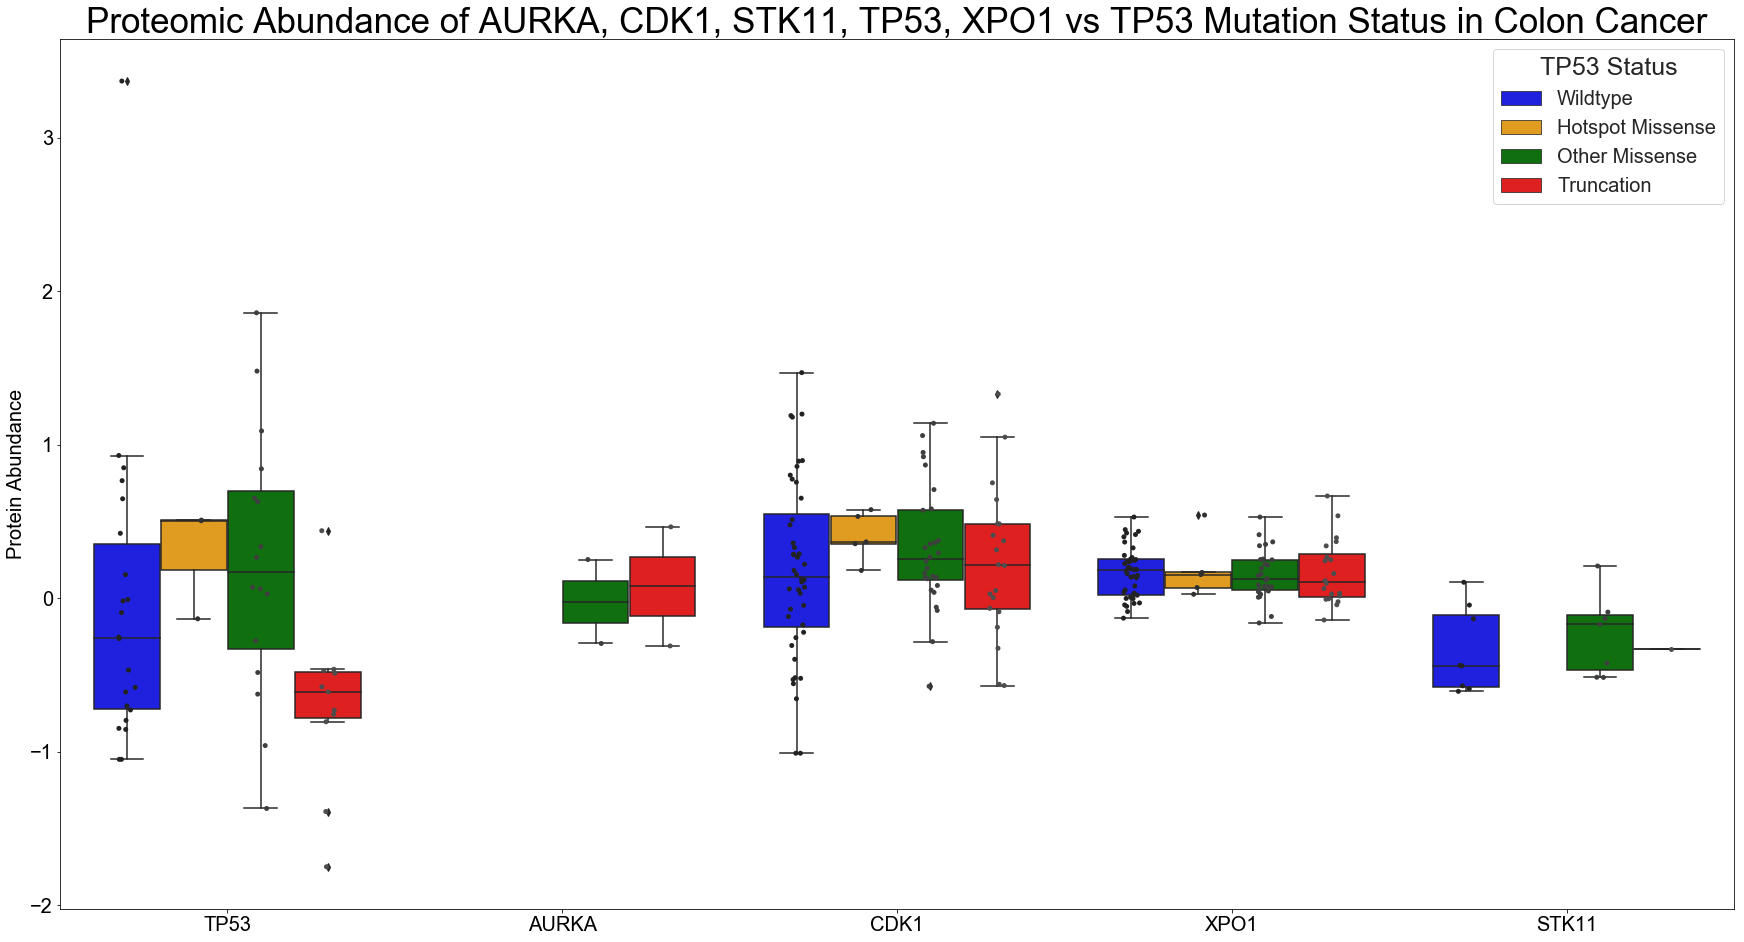

In [13]:
#Set dimensions and Colors
a4_dims = (30, 16)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Wildtype": "blue", "Hotspot Missense": "orange", "Other Missense":"green","Truncation":"red"}

#Make Boxplot
plot = sns.boxplot(data=plotdf, y = 'Abundance', x='Protein', hue='TP53_Categorical', palette=my_pal, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'], order=['TP53','AURKA','CDK1','XPO1','STK11'])

#Overlay Striplot
plot = sns.stripplot(data=plotdf, y = 'Abundance', x='Protein', hue='TP53_Categorical', color='.3', jitter=True, dodge=True, hue_order=['Wildtype','Hotspot Missense','Other Missense','Truncation'],order=['TP53','AURKA','CDK1','XPO1','STK11'])

#Change Style and label sizes
plot.tick_params(labelsize=20)
plot.set_xlabel('')
plot.set_ylabel('Protein Abundance', fontsize='20')
plot.set_title('Proteomic Abundance of AURKA, CDK1, STK11, TP53, XPO1 vs TP53 Mutation Status in Colon Cancer', fontsize = '35')
sns.set_style("white")

#Adjust the Legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],['Wildtype','Hotspot Missense','Other Missense','Truncation'], title='TP53 Status', fontsize='20', frameon=True)
plot.get_legend().get_title().set_fontsize('25')

# Hotspot debug:

In [29]:
#Use join omics to mutations
proteomics_df = co.join_omics_to_mutations(omics_genes=['TP53','AURKA','CDK1','XPO1','STK11'], omics_df_name='proteomics', mutations_genes='TP53')

#Remove Non-Tumor Samples
proteomics_df = proteomics_df.loc[proteomics_df['Sample_Status'] == 'Tumor']

#Remove columns that are not needed
proteomics_df = proteomics_df.drop(['Sample_Status'],axis=1)
proteomics_df['TP53_Hotspot_Mutation'] = binary_hotspots

#Show df
#proteomics_df.head()
for ind, row in proteomics_df.iterrows():
    if row['TP53_Mutation_Status'] == 'Wildtype_Tumor':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Wildtype'
    
    if row['TP53_Hotspot_Mutation'] != 'TP53_Hotspot_Mutation':
        if 'nonsynonymous SNV' in row['TP53_Mutation'] or 'nonframeshift deletion' in row['TP53_Mutation'] or 'nonframeshift insertion' in row['TP53_Mutation']:
            proteomics_df.loc[ind, 'TP53_Categorical'] = 'Other_Missense'
            
    if row['TP53_Hotspot_Mutation'] == 'TP53_Hotspot_Mutation':
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Hotspot_Missense'
        
    if 'frameshift insertion' in row['TP53_Mutation'] or 'frameshift deletion' in row['TP53_Mutation'] or 'stopgain' in row['TP53_Mutation']:
        proteomics_df.loc[ind, 'TP53_Categorical'] = 'Truncation'
        
        
        
proteomics_df = proteomics_df.drop(['TP53_Mutation', 'TP53_Mutation_Status'], axis = 1)
proteomics_df.head(55)

Name,TP53_proteomics,AURKA_proteomics,CDK1_proteomics,XPO1_proteomics,STK11_proteomics,TP53_Location,TP53_Hotspot_Mutation,TP53_Categorical
Patient_ID,,,,,,,,
S001,NaN,NaN,NaN,NaN,NaN,"[G113S, G113S, G113S, G206S, G206S, G206S, G20...",,Other_Missense
S002,-0.4890,-0.311,-0.5690,0.1610,NaN,"[E287Wfs*10, E194Wfs*11, E194Wfs*10, E167Wfs*2...",,Truncation
S003,-0.7960,NaN,-0.5570,0.0062,NaN,[No_mutation],,Wildtype
S004,NaN,NaN,-0.2220,0.1490,-0.607,[No_mutation],,Wildtype
S005,-1.3900,NaN,0.4860,0.3410,NaN,"[C143Y, C143Y, C116Y, C116Y, C116Y, S260Qfs*29...",,Truncation
S006,NaN,NaN,0.5330,0.0259,NaN,"[R273C, R273C, R273C, R273C, R234C, R234C, R23...",TP53_Hotspot_Mutation,Hotspot_Missense
S007,NaN,NaN,0.0605,0.2520,NaN,[No_mutation],,Wildtype
S008,NaN,NaN,0.2400,0.0469,-0.171,"[V164L, V164L, V203L, V164L, V164L, V203L, V20...",,Other_Missense
S009,-0.2630,NaN,1.2000,0.0196,NaN,[No_mutation],,Wildtype


In [25]:
hotspot_muts = []
for ind, row in proteomics_df.iterrows():
    if row['TP53_Hotspot_Mutation'] == 'TP53_Hotspot_Mutation':
        sample_muts = []
        for mut in row['TP53_Location']:
            sample_muts.append(mut)
        hotspot_muts.append(sample_muts)
            
for s in hotspot_muts:
    print(s, "\n")

['R273C', 'R273C', 'R273C', 'R273C', 'R234C', 'R234C', 'R234C', 'R114C', 'R114C', 'R114C', 'R141C', 'R141C', 'R141C', 'R234C', 'R234C'] 

['V31I', 'V31I', 'V31I', 'V31I'] 

['Q52X', 'Q52X', 'Q52X', 'Q52X', 'Q13X', 'Q13X', 'Q13X', 'Q13X', 'Q13X'] 

['S51Pfs*32', 'R136H', 'R136H', 'R136H', 'S51Pfs*32', 'S51Pfs*32', 'S51Pfs*32', 'S90Pfs*32', 'S90Pfs*32', 'S90Pfs*32', 'S90Pfs*32', 'R136H', 'S51Pfs*32', 'R136H', 'R43H', 'R43H', 'R43H', 'R16H', 'R16H', 'R175H', 'R175H', 'R175H', 'R175H', 'R16H'] 

['P152L', 'P113L', 'P113L', 'P113L', 'P152L', 'P20L', 'P20L', 'P20L', 'P113L', 'P113L', 'P152L', 'P152L'] 

['W14X', 'W53X', 'W14X', 'W53X', 'W53X', 'W53X', 'W14X', 'W14X', 'W14X'] 

['G86S', 'G113S', 'G86S', 'G86S', 'G206S', 'G206S', 'G206S', 'G206S', 'G206S', 'G245S', 'G245S', 'G245S', 'G245S', 'G113S', 'G113S'] 

['S33Ffs*7', 'S33Ffs*7', 'S33Ffs*7', 'S33Ffs*7'] 

['P31L', 'P31L', 'P31L', 'P58L', 'P58L', 'P58L', 'P190L', 'P190L', 'P190L', 'P190L', 'P151L', 'P151L', 'P151L', 'P151L', 'P151L'] 



In [40]:
hs = []
for ind, row in proteomics_df.iterrows():
    for loc in row['TP53_Location']:
        if '52' in loc or '53' in loc:
            if ind not in hs:
                hs.append(ind)
            #print(row['TP53_Location'])
            
hs

['S005', 'S022', 'S031', 'S053', 'S073', 'S108']

In [41]:
binary[['TP53','TP53_1']]

,TP53,TP53_1
sample_id,,
S001,False,False
S002,False,False
S003,False,False
S004,False,False
S005,False,False
S006,False,True
S007,False,False
S008,False,False
S009,False,False


vis, binary, detailed, dictionary

In [53]:
dictionary['TP53_1']

['p.S33Ffs*7', 'p.V31I']

In [54]:
dictionary['TP53']

['p.Q52X', 'p.W53X']

Hotspot mutations are 'p.S33Ffs*7', 'p.V31I', 'p.Q52X', 'p.W53X' <br>
According to detailed, hotspot samples are: 006, 014, 022, 030, 031, 053, 054, 075, 076 <br>
According to binary, hotspot samples are: 006, 014, 022, 030, 053, 075

In [59]:
hs = []
for ind, row in proteomics_df.iterrows():
    #print(row['TP53_Location'])
    if 'S33Ffs*7' in row['TP53_Location'] or 'V31I' in row['TP53_Location'] or 'Q52X' in row['TP53_Location'] or 'W53X' in row['TP53_Location']:
        hs.append(ind)
        
        
hs

['S014', 'S022', 'S053', 'S075']

In [63]:
t = proteomics_df.loc['S022']
t['TP53_Location']

['Q52X', 'Q52X', 'Q52X', 'Q52X', 'Q13X', 'Q13X', 'Q13X', 'Q13X', 'Q13X']

In [64]:
for ind, row in proteomics_df.iterrows():
    for mut in row['TP53_Location']:
        if '273' in mut:
            print(ind, ": ", mut)

S006 :  R273C
S006 :  R273C
S006 :  R273C
S006 :  R273C
S021 :  R273C
S021 :  R273C
S021 :  R273C
S021 :  R273C
S032 :  R273H
S032 :  R273H
S032 :  R273H
S032 :  R273H
S039 :  R273C
S039 :  R273C
S039 :  R273C
S039 :  R273C
S046 :  R273C
S046 :  R273C
S046 :  R273C
S046 :  R273C
S067 :  R273H
S067 :  R273H
S067 :  R273H
S067 :  R273H
S087 :  R273C
S087 :  R273C
S087 :  R273C
S087 :  R273C
